# Maize Yield Analysis

For this study we processed maize yield data from 1990 to 2021 for Benin and Togo at the level of administrative regions 1 and 2. NDVI and VEI data from MODIS were used to assess vegetation cover at a resolution of 0.05 degrees over the period 2002 to 2024. NDVI and VEI values are aggregated by administrative level to correspond to maize yield data. The data were log-transformed to stabilize variances and treat outliers. Finally, we used a RidgeCV regression model to predict maize yields at administrative levels 1 and 2.

In [3]:
# the libraries required for the script
import os
import geopandas as gpd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
import rioxarray
import matplotlib.patches as mpatches

##### Set the working directory


In [4]:
os.chdir('D:/LabTogo/TechnicalAssessment/')
os.makedirs('products', exist_ok=True)

## Task 1: Data Cleaning and Exploration

### Task 1.1: Import and merge administrative boundary files for Togo and Benin

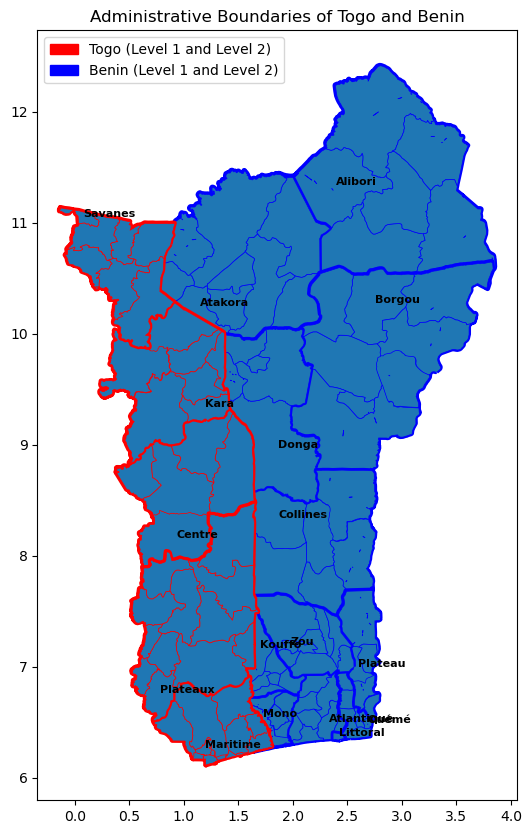

In [5]:
# I import the GeoJSON files for Togo and Beninn at level 2
togo = gpd.read_file('data/administrative_boundaries/gadm41_TGO_2.geojson')
benin = gpd.read_file('data/administrative_boundaries/gadm41_BEN_2.geojson')

# here I merge the two files for beni and togo
boundaries = pd.concat([togo, benin])

# Here, I plot the administrative polygons with different colors and for each country ( togo will be in red and Benin in Bleu)
fig, ax = plt.subplots(figsize=(10, 10))
for country, data in boundaries.groupby('COUNTRY'):
    color = 'red' if country == 'Togo' else 'blue'
    for level_1, group_1 in data.groupby('NAME_1'):
        group_1.plot(ax=ax, edgecolor=color, linewidth=3.5)
        for level_2, group_2 in group_1.groupby('NAME_2'):
            group_2.plot(ax=ax, edgecolor=color, linewidth=0.5)

# Add labels for the level2 for togo and Benin
labeled_regions = set()
for idx, row in boundaries.iterrows():
    if row['NAME_1'] not in labeled_regions:
        color = 'black' if row['COUNTRY'] == 'Togo' else 'black'
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, s=row['NAME_1'], fontsize=8, color=color, weight='bold')
        labeled_regions.add(row['NAME_1'])
        
plt.title('Administrative Boundaries of Togo and Benin')
red_patch = mpatches.Patch(color='red', label='Togo (Level 1 and Level 2)')
blue_patch = mpatches.Patch(color='blue', label='Benin (Level 1 and Level 2)')
plt.legend(handles=[red_patch, blue_patch], loc='upper left')
plt.savefig('products/1.1.jpeg')
plt.show()

- This map shows the level 1 and 2 administrative boundaries of Togo and Benin. The borders of Togo are shown in red, while those of Benin are shown in blue. this allows the two countries to be identified on the map

- The boundaries of  level 1 are represented by thicker lines, while the boundaries of the level 2 are drawn with thinner lines. This differentiation facilitates the classification of administrative divisions and makes the two levels more visible.

- As far as level 1 are concerned, Benin has much larger regions in the north and smaller ones in the south, while Togo's regions are relatively uniform in size.

### Task 1.2: Import and explore maize yield data
#### Load maize yield data

In [44]:
# this line allow to import the yield data
yield_data = pd.read_csv('data/administrative_yield/fews_net_yield_TGO_BEN.csv')

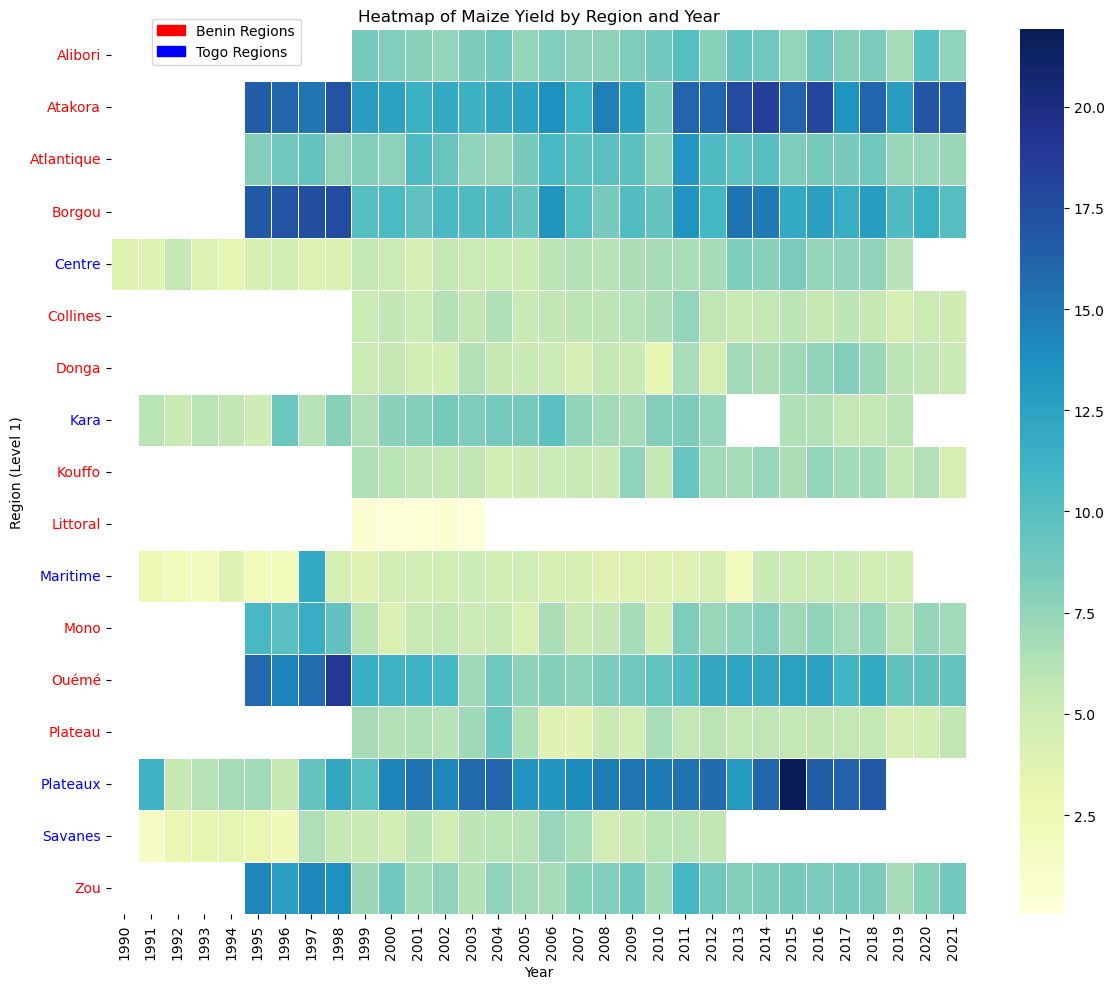

In [45]:
# Create a pivot teble for the heatmap. The data is aggregated at level 1, taking the sum to see the total production at each level.
y_pivot = yield_data.pivot_table(index='admin_1', columns='year', values='value',aggfunc='sum')

# Plot heatmap of maize yield by region and year for the two counntry
plt.figure(figsize=(12, 10))
plt.title('Heatmap of Maize Yield by Region and Year')
ax = sns.heatmap(y_pivot, cmap='YlGnBu', annot=False, linewidths=.5)
plt.xlabel('Year')
plt.ylabel('Region (Level 1)')

# Give region names a color basedd on the country to differentiate them. 
for text in ax.get_yticklabels():
    region_name = text.get_text()
    country = yield_data[yield_data['admin_1'] == region_name]['country'].iloc[0]
    text.set_color('red' if country == 'Benin' else 'blue')

red_patch = mpatches.Patch(color='red', label='Benin Regions')
blue_patch = mpatches.Patch(color='blue', label='Togo Regions')
plt.legend(handles=[red_patch, blue_patch], loc='upper left', bbox_to_anchor=(0.04, 1.02))
plt.tight_layout()
plt.savefig('products/1.2.a.png')
plt.show()


- This map shows maize yields in the Benin and Togo regions between 1990 and 2021.
- The higher the intensity, the greater the maize yield.
- To distinguish the Benin and Togo regions, we have highlighted the Benin region in red and the Togo region in blue.
- This figure is important because it shows maize yields over time and their variations. It also allows us to detect years with missing values, as in the case of the Littoral region (Level1), which recorded very little data. It also gives an overview of the main maize-producing regions and the years with the highest production. This shows, for example, that the northern regions of Benin (Alibori, Atakora, Borgou) have a greater maize production capacity, showing a spatial distribution of yields. In addition, the Borgou, Atakora and Plateau regions show much higher annual yields over time than other regions, showing a temporal distribution. For example, the years 1995 to 1998 were high-yield years for many regions of Benin.
- 
Other regions, such as Collines, Littoral, Maritine and Kouffo, have seen low production over the years. However, Benin's total maize production is much higher than that of Togo. This can be explained by the much larger surface area of some of Benin's regions, but also by weather conditions or country policies aimed at improving crop yields. Similarly, Benin's regions generally show greater variation in maize yields over time than Togo's, particularly in northern regions such as Alibori, Borgou, Ouémé and Atacora.


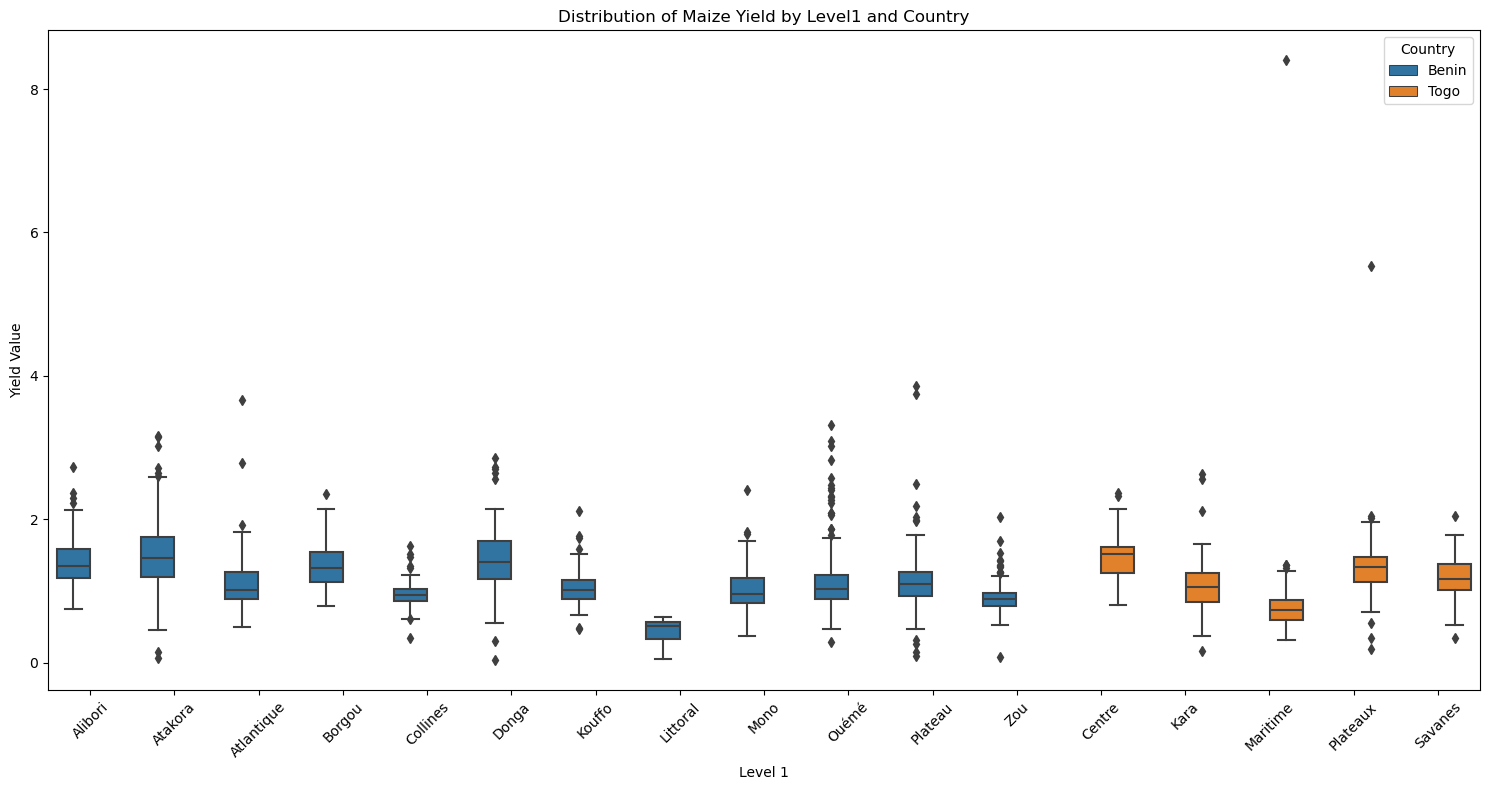

In [46]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='admin_1', y='value', hue='country', data=yield_data)
plt.title('Distribution of Maize Yield by Level1 and Country')
plt.xticks(rotation=45)  
plt.xlabel('Level 1')
plt.ylabel('Yield Value')
plt.legend(title='Country', loc='upper right')
plt.tight_layout()
plt.savefig('products/1.2.b.png')
plt.show()

- Some regions of Benin (such as Alibori, Atacora, Ouémé) show greater variability, with several outliers.
- Regions in Togo (such as Savanes and Maritime) have tighter distributions, but outliers are also present.

### Task 1.3 Visit the FAO GIEWS website for Togo. What is the typical timeline for maize production in 
Tog?

The typical timeline for maize production in Togo varies by region due to climatic differences between the northern and southern parts of the country.
According to the FAO GIEWS website,In southern Togo,  which benefits from two rainy seasons (bimodal rainfall pattern), there are generally two maize cultivation cycles per year:

- First season:
  - Planting: March to April
  - Growing: May to July
  - Harvesting: August to September
- Second season:
    - Planting: August to September
    - Growing : October to November
    - Harvesting: December to january
 

In northern Togo, where there is a single rainy season (unimodal rainfall), maize is cultivated once a year. The rainy season is between May and September

### Task 1.4: Import MODIS VI data

In [13]:
# This imports data from the VI (MODIS Data)
vi_data = xr.open_dataset('data/modis_vegetation_indices/modis_vi.nc', engine='netcdf4')
print(vi_data['NDVI'].attrs)

{'add_offset_err': 0, 'calibrated_nt': 5, 'long_name': 'CMG 0.05 Deg Monthly NDVI', 'scale_factor_err': 0, 'units': 'NDVI', 'valid_range': '-2000, 10000', 'grid_mapping': 'spatial_ref'}


- valid_range: -2000, 10000: This means that the NDVI values in the NetCDF file are within this range before scaling.


In [14]:
vi_data = xr.open_dataset('data/modis_vegetation_indices/modis_vi.nc', engine='netcdf4')
print(vi_data['NDVI'].min().values, vi_data['NDVI'].max().values) # show the max value of NDVI
print(vi_data['EVI'].min().values, vi_data['EVI'].max().values) # show the max value of VEI

-19820000.0 97840000.0
-14870000.0 85330000.0


- The data show that the actual values range from [-19,820,000.0, 97,840,000.0] for NDVI to [-14,870,000.0, 85,330,000.0] for EVI.
- There seems to be an error, as the data is larger than the information we get by applying the 'attrs' function.
- I'll apply a scaling factor of 1e-8 and hide values below 0 to focus only on vegetated areas since we're working on agricultural yield].


In [15]:

# Apply scale factor 
scale_factor = 1e-8
vi_data['NDVI'] = vi_data['NDVI'] * scale_factor
vi_data['EVI'] = vi_data['EVI'] * scale_factor

# In the Data Description, -3000 would be a missing value, but we can see here that some values are smaller than -3000.
# So the best thing I could do was to hide the negative values, because NDVI varies between 0.2 to 1
vi_data['NDVI'] = vi_data['NDVI'].where(vi_data['NDVI'] >= 0)
vi_data['EVI'] = vi_data['EVI'].where(vi_data['EVI'] >= 0)

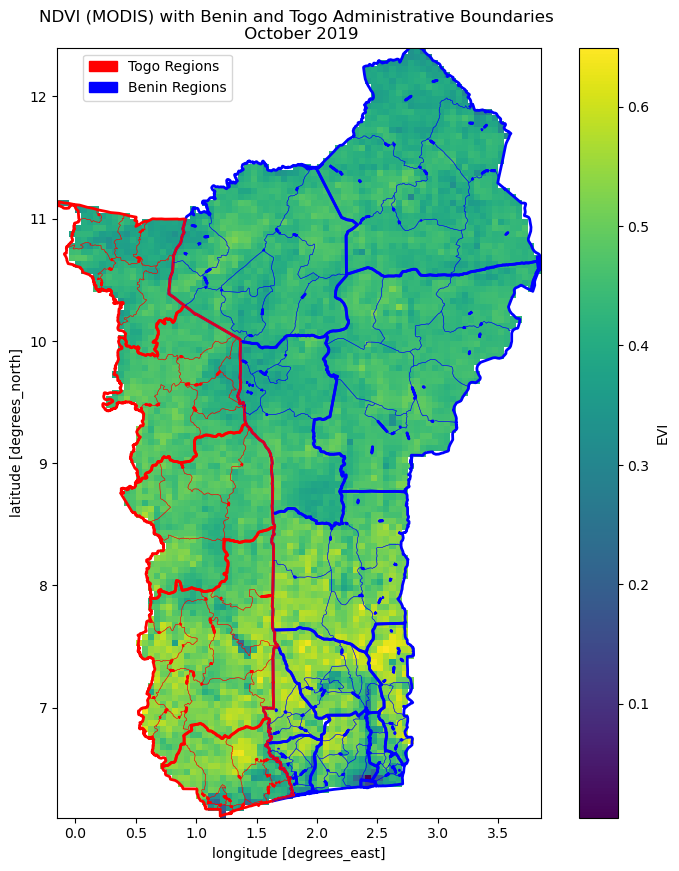

In [16]:
# we want to extract the data for one month. so we will take october 2019
ndvi = vi_data['EVI'].sel(time='2019-10')
#It is important to ensure CRS consistency between NDVI and boundaries
ndvi = ndvi.rio.write_crs(boundaries.crs, inplace=True)

# Clip NDVI to the boundaries of Togo and Benin. this will allow us to have the data between the boundaries of the two country
ndvi_clipped = ndvi.rio.clip(boundaries.geometry, drop=True)

# the script make the plot for NDVI, level 1 and level 2, then overlay them.

fig, ax = plt.subplots(figsize=(10, 10))
# Plot the clipped NDVI data
ndvi_clipped.plot(ax=ax, cmap='viridis')

# Plot level 1 boundaries
level_1_boundaries = boundaries.dissolve(by='NAME_1')
for country, data in level_1_boundaries.groupby('COUNTRY'):
    color = 'red' if country == 'Togo' else 'blue'
    data.boundary.plot(ax=ax, edgecolor=color, linewidth=2)

# Plot level 2 boundaries
level_2_boundaries = boundaries.dissolve(by='NAME_2')
for country, data in level_2_boundaries.groupby('COUNTRY'):
    color = 'red' if country == 'Togo' else 'blue'
    data.boundary.plot(ax=ax, edgecolor=color, linewidth=0.3)

plt.title('NDVI (MODIS) with Benin and Togo Administrative Boundaries \n October 2019')
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Togo Regions')
blue_patch = mpatches.Patch(color='blue', label='Benin Regions')
plt.legend(handles=[red_patch, blue_patch], loc='upper left', bbox_to_anchor=(0.04, 1.0))
plt.savefig('products/1.4.png')
plt.show()

- The map below shows the VEI values for October 2019, superimposed on the administrative regions of Benin and Togo.
- To keep the difference between Togo and Benin clear, we've kept the colors red for Togo and blue for Benin.
- This map shows higher VEI values in the south of both regions, indicating good health or vegetation cover in the south of both countries in the month of October.
- 
Looking at the administrative regions, we can see that the level 1 regions are very small for the MODIS data resolution of 5.6 Km. It would be difficult to capture the variation within each administrative level 2 with good precision. Smaller levels will only be covered by a few pixels, if any at all, depending on the size of the administrative division, which limits the value of the information we can extract. Thus vegetation variations in small localities may not be captured, which could affect the prediction of agricultural yields, particularly at level 2
- 
Modis VI data, with its 5.6km resolution, is best suited to regional analysis of large administrative areas. For larger areas such as level 1, vegetation data will provide much more reliable information. This means that an approach based on aggregated analysis at level 1 could be more effective for agricultural yields in Benin and Togo.



# Task 2: Geospatial Data Wrangling

## 2.1 Extract vegetation features from the VI data.

In [92]:

vi_data = vi_data.rio.write_crs(boundaries.crs, inplace=True)

# we will store the values in this list features
features = []

# Extraction of the mean, min, and max values for each level
for month in pd.date_range(start='2002-01', end='2024-07', freq='M'):
    for vi in ['NDVI', 'EVI']:
        try:
            vi_month = vi_data[vi].sel(time=month, method='pad')
        except KeyError:
            continue 

        vi_clipped = vi_month.rio.clip(boundaries.geometry, drop=True)
        
        for idx, row in boundaries.iterrows():
            masked = vi_clipped.rio.clip([row.geometry], drop=True)
            mean_val = masked.mean().values.item() if masked.size > 0 else np.nan
            min_val = masked.min().values.item() if masked.size > 0 else np.nan
            max_val = masked.max().values.item() if masked.size > 0 else np.nan
            
            features.append({
                'year': month.year,
                'month': month.month,
                'country': row['COUNTRY'],
                'name_1': row['NAME_1'],
                'name_2': row['NAME_2'],
                'vi': vi,
                'mean': mean_val,
                'min': min_val,
                'max': max_val
            })

# Convert feature to DataFrame(df)
features_df = pd.DataFrame(features)
features_df.to_csv('products/2.1_data.csv', index=False)


In [93]:
features_df

year  month country  name_1      name_2    vi      mean     min     max
0      2002      7    Togo  Centre      Blitta  NDVI  0.744607  0.6564  0.8341
1      2002      7    Togo  Centre          Mô  NDVI  0.759922  0.7016  0.8259
2      2002      7    Togo  Centre   Sotouboua  NDVI  0.723608  0.6231  0.8154
3      2002      7    Togo  Centre     Tchamba  NDVI  0.731899  0.6247  0.7943
4      2002      7    Togo  Centre    Tchaudjo  NDVI  0.720066  0.5833  0.7863
...     ...    ...     ...     ...         ...   ...       ...     ...     ...
62299  2024      6   Benin     Zou      Djidja   EVI  0.466551  0.3798  0.5362
62300  2024      6   Benin     Zou      Ouinhi   EVI  0.480658  0.4514  0.5194
62301  2024      6   Benin     Zou    Za-Kpota   EVI  0.455743  0.3759  0.5018
62302  2024      6   Benin     Zou   Zagnanado   EVI  0.513294  0.3968  0.5859
62303  2024      6   Benin     Zou  Zogbodomey   EVI  0.532026  0.4678  0.5987

[62304 rows x 9 columns]

In [17]:
#features_df = pd.read_csv('products/2.1_Data.csv')
#features_df

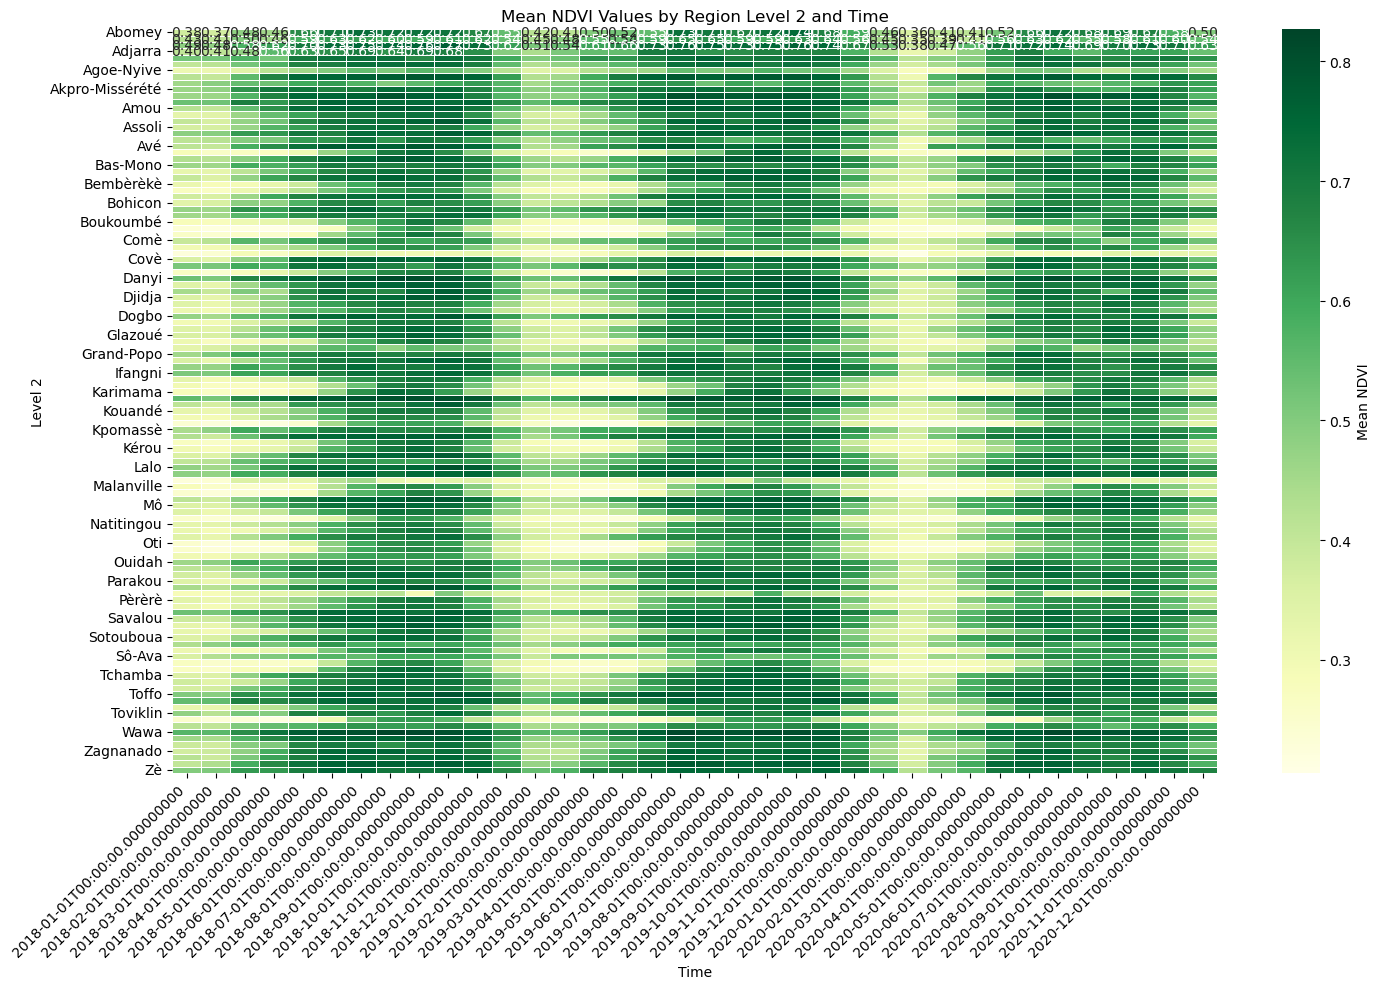

In [18]:
# we select 3 years for this map, to have litle more clear maps
years = [2018, 2019, 2020]
mean_ndvi_df = features_df[
    (features_df['vi'] == 'NDVI') & 
    (features_df['year'].isin(years))
].groupby(['year', 'month', 'name_2'])['mean'].mean().reset_index()

# create a colone date to combine year and moths
mean_ndvi_df['Date'] = pd.to_datetime(mean_ndvi_df[['year', 'month']].assign(day=1))
# pivot for leval2 and agregate to have the mean value
ndvi_pivot = mean_ndvi_df.pivot_table(index='name_2', columns='Date', values='mean', aggfunc='mean')

# Plot
plt.figure(figsize=(15, 10))
sns.heatmap(ndvi_pivot, cmap='YlGn', linewidths=0.5, annot=True, fmt=".2f", cbar_kws={'label': 'Mean NDVI'})
plt.title('Mean NDVI Values by Region Level 2 and Time')
plt.xlabel('Time')
plt.ylabel('Level 2')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('products/2.1.a.png')
plt.show()

This figure shows low NDVI values during the period from December to February/March, when vegetation levels are very low. It therefore represents the dry period for December to February and March for the start of the rainy season.
Similarly, the values for the dry season are almost uniform for each level (locality), but the start of the rainy season is different for certain regions, which is normal since Togo and Benin have two rainy seasons in the south and only one in the north.


C:\Users\YOuedraogo\AppData\Local\Temp\ipykernel_24248\276663498.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


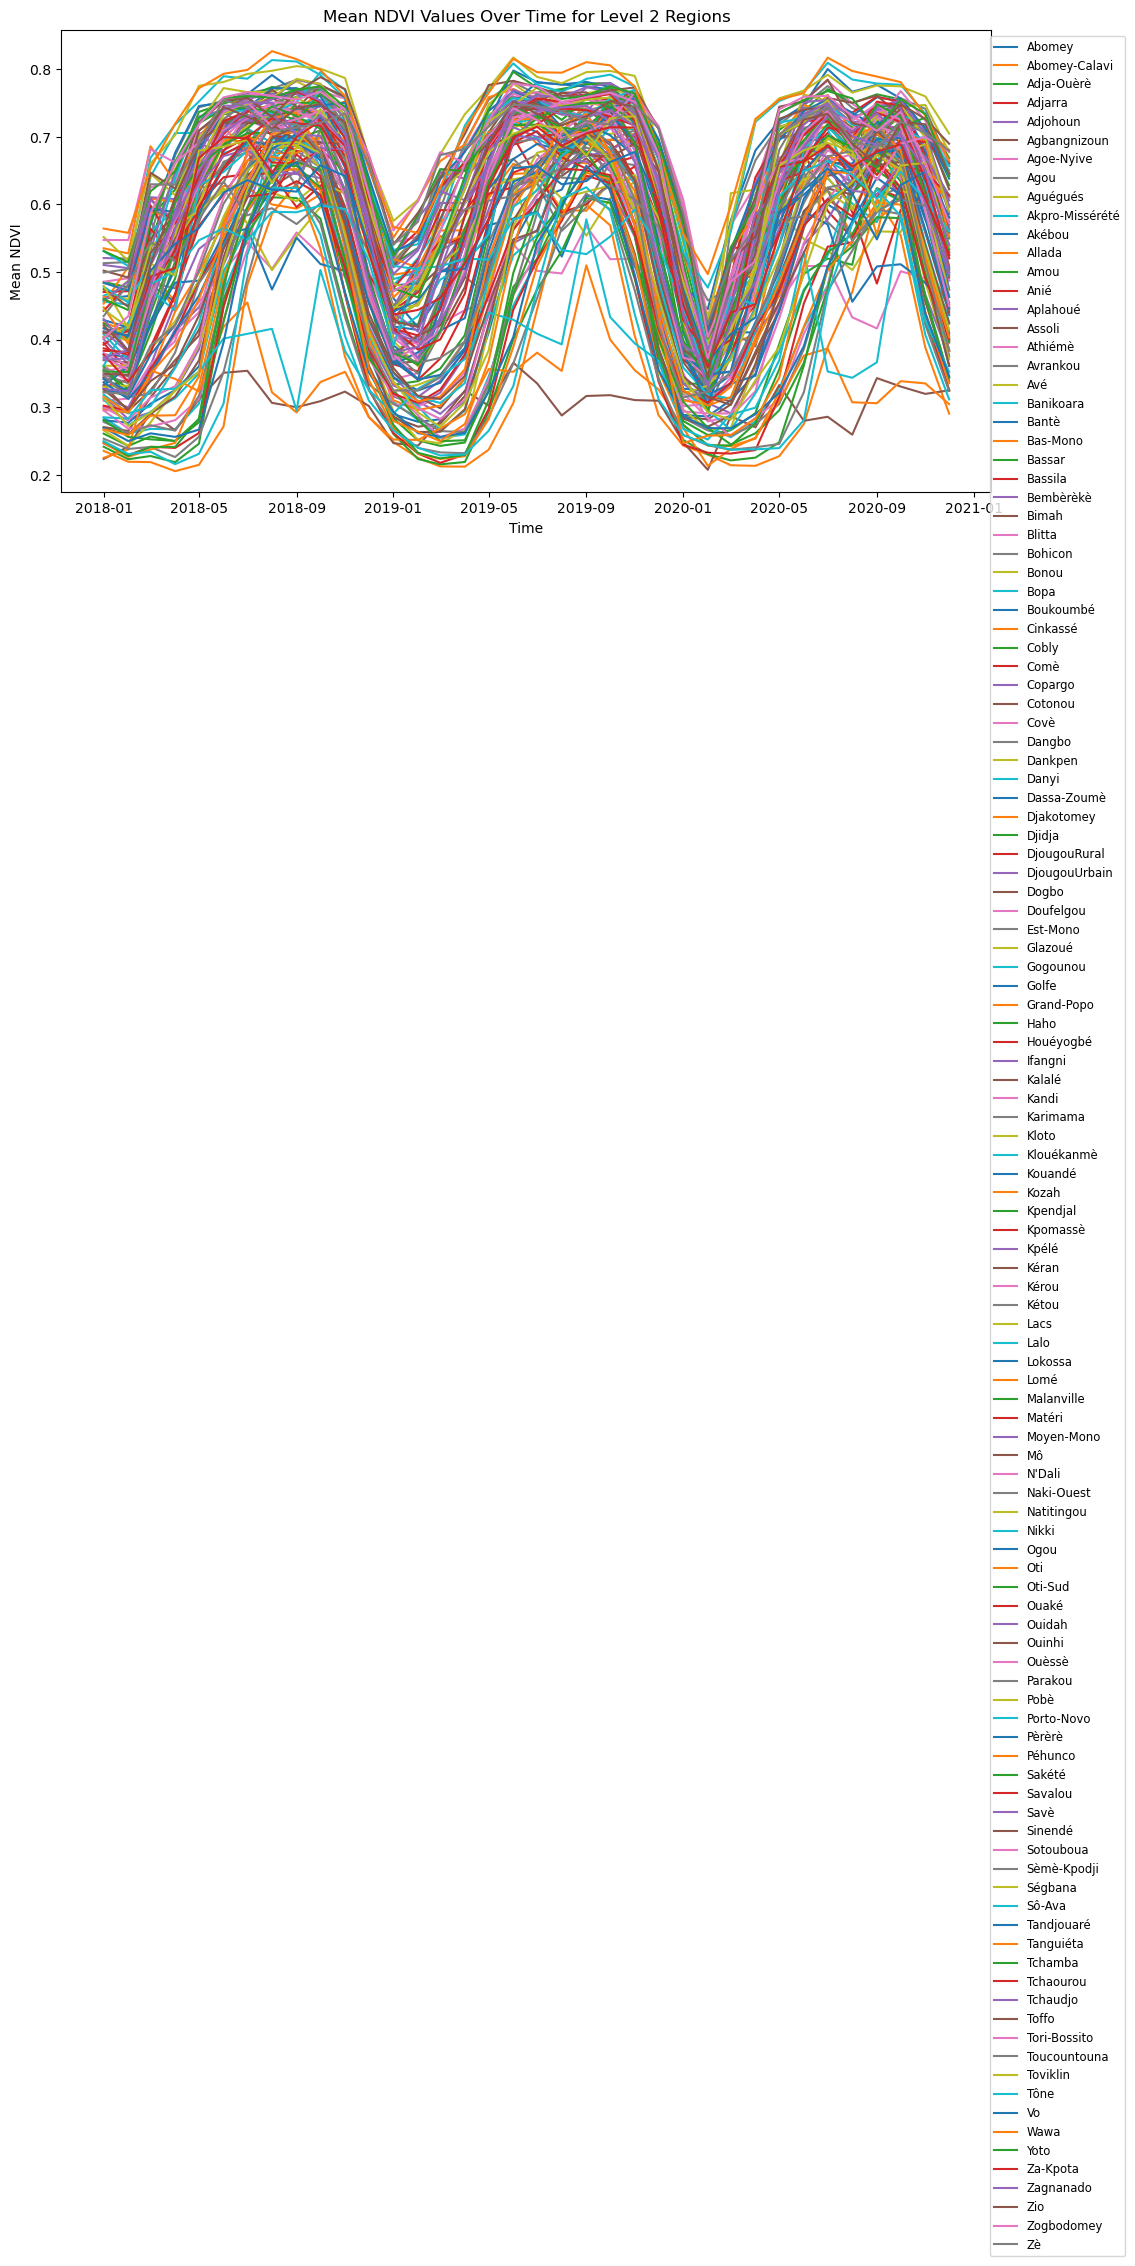

In [19]:

# I chose 3 years for this exercise to see the fluctuation of NDVI over time.
years = [2018, 2019,2020]
mean_ndvi_df = features_df[(features_df['vi'] == 'NDVI') & (features_df['year'].isin(years))].groupby(['year', 'month', 'name_2'])['mean'].mean().reset_index()

# the mean values of NDVi
fig, ax = plt.subplots(figsize=(12, 6))
for name_2, group in mean_ndvi_df.groupby('name_2'):
    ax.plot(pd.to_datetime(group[['year', 'month']].assign(day=1)), group['mean'], label=name_2)

plt.title('Mean NDVI Values Over Time for Level 2 Regions')
plt.xlabel('Time')
plt.ylabel('Mean NDVI')
plt.legend(loc='upper right', fontsize='small', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.savefig('products/2.1.b.png')
plt.show()

- The graph above shows average normalized vegetation index (NDVI) values over time for different level 2 administrative regions in Benin and Togo, over a period from January 2018 to January 2020.
- Similarly, the significant drops in NDVI values, generally observed around the months of December to February, suggest dry periods. This corresponds well with the dry seasons in togo and Benin.
- NDVI values generally peak around June-July, corresponding to the growing season for crops such as maize in togo and Benin. This peak is followed by a gradual decline, suggesting the end of the growing season and harvesting.


## 2.2 Reshape the extracted data into a wide format such that there is a single row for each unique combination of country, administrative level 1, administrative level 2, and year.

In [20]:
# Reshape the extracted data into wide format
wide_df = features_df.pivot_table(index=['country', 'name_1', 'name_2', 'year'],
                                  columns=['vi', 'month'],
                                  values=['mean', 'min', 'max'])
wide_df.columns = [f'{vi}_{stat}_{month:02d}' for stat, vi, month in wide_df.columns]
wide_df.reset_index(inplace=True)
wide_df.to_csv('products/features_data2.csv', index=False)


In [21]:
wide_df

country   name_1     name_2  year  EVI_max_01  EVI_max_02  EVI_max_03  \
0      Benin  Alibori  Banikoara  2002         NaN         NaN         NaN   
1      Benin  Alibori  Banikoara  2003      0.1977      0.1892      0.1802   
2      Benin  Alibori  Banikoara  2004      0.1950      0.1762      0.1731   
3      Benin  Alibori  Banikoara  2005      0.1855      0.1675      0.1737   
4      Benin  Alibori  Banikoara  2006      0.1912      0.1817      0.1877   
...      ...      ...        ...   ...         ...         ...         ...   
2709    Togo  Savanes       Tône  2020      0.1804      0.1720      0.1819   
2710    Togo  Savanes       Tône  2021      0.1898      0.1824      0.1700   
2711    Togo  Savanes       Tône  2022      0.1822      0.1756      0.1629   
2712    Togo  Savanes       Tône  2023      0.1867      0.1754      0.1780   
2713    Togo  Savanes       Tône  2024      0.1851      0.1709      0.1756   

      EVI_max_04  EVI_max_05  EVI_max_06  ...  NDVI_min_03  NDVI_min_04  \
0            NaN         NaN         NaN  ...          NaN          NaN   
1         0.2624      0.3254      0.4521  ...       0.2224       0.2473   
2         0.2502      0.3164      0.4008  ...       0.2120       0.2195   
3         0.2224      0.3294      0.4199  ...       0.1862       0.2281   
4         0.2152      0.2462      0.3732  ...       0.2253       0.2207   
...          ...         ...         ...  ...          ...          ...   
2709      0.2086      0.2066      0.2409  ...       0.2129       0.2048   
2710      0.1702      0.2050      0.2241  ...       0.2135       0.2116   
2711      0.1913      0.2619      0.3037  ...       0.2033       0.2103   
2712      0.1722      0.1919      0.2482  ...       0.2220       0.2082   
2713      0.1806      0.1692      0.2174  ...       0.2152       0.2154   

      NDVI_min_05  NDVI_min_06  NDVI_min_07  NDVI_min_08  NDVI_min_09  \
0             NaN          NaN       0.3668       0.5818       0.6626   
1          0.2559       0.3729       0.5283       0.6533       0.6490   
2          0.2602       0.3647       0.4283       0.5687       0.6629   
3          0.2584       0.3001       0.4407       0.4269       0.6391   
4          0.2436       0.2554       0.3020       0.5536       0.6576   
...           ...          ...          ...          ...          ...   
2709       0.2051       0.2238       0.2908       0.4899       0.5460   
2710       0.2152       0.2258       0.2673       0.5492       0.5888   
2711       0.2216       0.2688       0.2858       0.4705       0.5491   
2712       0.2150       0.2531       0.2930       0.5593       0.5831   
2713       0.2142       0.2256          NaN          NaN          NaN   

      NDVI_min_10  NDVI_min_11  NDVI_min_12  
0          0.5758       0.3799       0.3005  
1          0.5264       0.3896       0.2682  
2          0.5458       0.3602       0.2450  
3          0.5849       0.3689       0.2715  
4          0.6271       0.4379       0.2989  
...           ...          ...          ...  
2709       0.5443       0.3798       0.2869  
2710       0.5250       0.3718       0.2860  
2711       0.5400       0.3588       0.2845  
2712       0.5144       0.3730       0.2836  
2713          NaN          NaN          NaN  

[2714 rows x 76 columns]

- we thus put the data into a large format enabling data to be prepared for the predictive model. Predictive models require observations in vector form, where each row of data is an observation with all the relevant characteristics, making it easier to train the regression models.
- By associating each line with a unique combination of country, region and year, it is simpler to merge this data with agricultural yields, which are aggregated at this same level.
- This is especially important as it allows NDVI/VEI values for each month or growing period to be captured and related to crop yields. By having vegetation indices available for each month, it becomes possible to understand the impact of monthly climatic conditions on maize yields for the agricultural season.


# 2.3 Merge the vegetation features with the maize yield data.

In [22]:
# Merge the vegetation features with the maize yield data
yield_data.rename(columns={'admin_1': 'name_1', 'admin_2': 'name_2'}, inplace=True)
merg_df = pd.merge(wide_df, yield_data, on=['country', 'name_1', 'name_2', 'year'], how='inner')


In [23]:
merg_df.to_csv('products/2.3_Data.csv', index=False)

In [24]:
merg_df = pd.read_csv('products/2.3_Data.csv')
merg_df

country   name_1     name_2  year  EVI_max_01  EVI_max_02  EVI_max_03  \
0      Benin  Alibori  Banikoara  2002         NaN         NaN         NaN   
1      Benin  Alibori  Banikoara  2003      0.1977      0.1892      0.1802   
2      Benin  Alibori  Banikoara  2004      0.1950      0.1762      0.1731   
3      Benin  Alibori  Banikoara  2005      0.1855      0.1675      0.1737   
4      Benin  Alibori  Banikoara  2006      0.1912      0.1817      0.1877   
...      ...      ...        ...   ...         ...         ...         ...   
1992    Togo  Savanes       Tône  2008      0.1625      0.1564      0.1544   
1993    Togo  Savanes       Tône  2009      0.1718      0.1655      0.1604   
1994    Togo  Savanes       Tône  2010      0.1737      0.1641      0.1542   
1995    Togo  Savanes       Tône  2011      0.1722      0.1691      0.1677   
1996    Togo  Savanes       Tône  2012      0.1716      0.1654      0.1520   

      EVI_max_04  EVI_max_05  EVI_max_06  ...  NDVI_min_08  NDVI_min_09  \
0            NaN         NaN         NaN  ...       0.5818       0.6626   
1         0.2624      0.3254      0.4521  ...       0.6533       0.6490   
2         0.2502      0.3164      0.4008  ...       0.5687       0.6629   
3         0.2224      0.3294      0.4199  ...       0.4269       0.6391   
4         0.2152      0.2462      0.3732  ...       0.5536       0.6576   
...          ...         ...         ...  ...          ...          ...   
1992      0.1636      0.2406      0.3246  ...       0.5621       0.5661   
1993      0.1738      0.2248      0.3619  ...       0.4678       0.5638   
1994      0.1543      0.1828      0.2784  ...       0.4975       0.5635   
1995      0.1682      0.1825      0.2321  ...       0.4688       0.5534   
1996      0.1909      0.2668      0.2742  ...       0.4427       0.5736   

      NDVI_min_10  NDVI_min_11  NDVI_min_12  season_name  season_type  \
0          0.5758       0.3799       0.3005         Main      Harvest   
1          0.5264       0.3896       0.2682         Main      Harvest   
2          0.5458       0.3602       0.2450         Main      Harvest   
3          0.5849       0.3689       0.2715         Main      Harvest   
4          0.6271       0.4379       0.2989         Main      Harvest   
...           ...          ...          ...          ...          ...   
1992       0.5118       0.3544       0.2773         Main      Harvest   
1993       0.5325       0.3970       0.2843         Main      Harvest   
1994       0.5523       0.4251       0.2854         Main      Harvest   
1995       0.5297       0.3655       0.2739         Main      Harvest   
1996       0.5202       0.3633       0.2791         Main      Harvest   

         value   unit       product  
0     1.194343  MT/ha  Maize (Corn)  
1     1.468042  MT/ha  Maize (Corn)  
2     1.454900  MT/ha  Maize (Corn)  
3     1.501367  MT/ha  Maize (Corn)  
4     1.375722  MT/ha  Maize (Corn)  
...        ...    ...           ...  
1992  0.920000  MT/ha  Maize (Corn)  
1993  0.950000  MT/ha  Maize (Corn)  
1994  1.080000  MT/ha  Maize (Corn)  
1995  1.050000  MT/ha  Maize (Corn)  
1996  1.010000  MT/ha  Maize (Corn)  

[1997 rows x 81 columns]

The use of an inner join ensures that the merged data are consistent and contain only observations for which both datasets (vegetation characteristics and maize yield) are available. This is useful for avoiding biases introduced by missing values.

# Task 3: Linear Modeling and Results Interpretation

### 3.1 Compare the distribution of yields to a log transformation of yields. Which values will you use in your model and why?

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


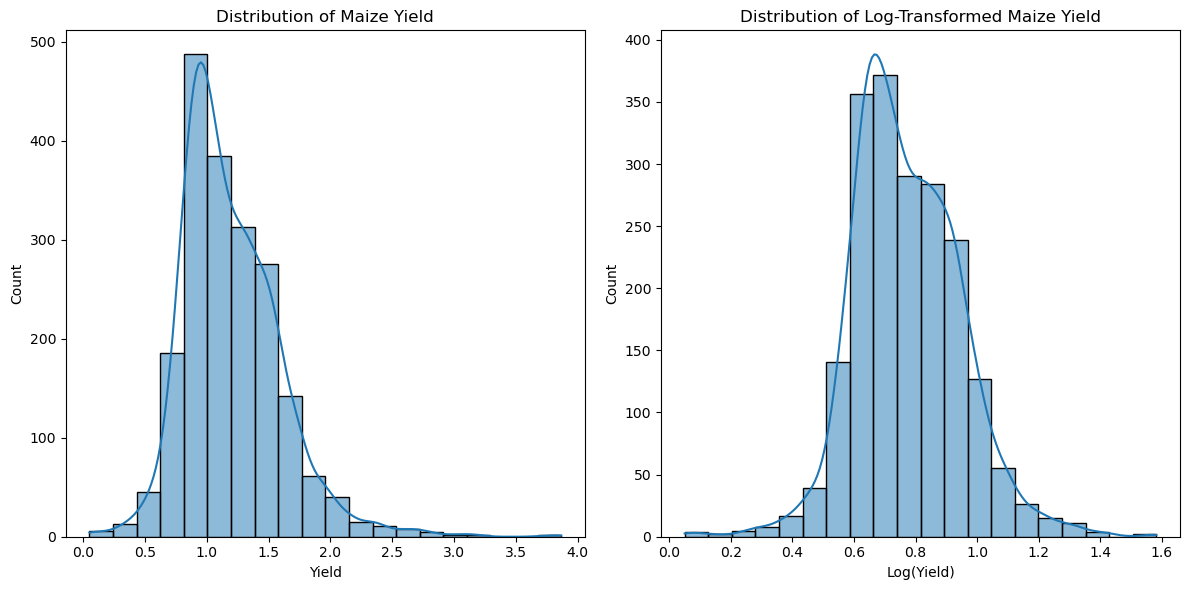

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(merg_df['value'], bins=20, kde=True)
plt.title('Distribution of Maize Yield')
plt.xlabel('Yield')

plt.subplot(1, 2, 2)
log_yield = np.log1p(merg_df['value'])
sns.histplot(log_yield, bins=20, kde=True)
plt.title('Distribution of Log-Transformed Maize Yield')
plt.xlabel('Log(Yield)')

plt.tight_layout()
plt.savefig('products/3.1.png')
plt.show()

#### Interpretation of which values to use in the model
In this section, we applied a logarithmic transformation to the yields for comparison with the non-transformed values, before moving on to the RidgeCV medel.
- Comparing the two graphs, we can see that the distribution of maize yields without any transformation (left) is asymmetrical, which violates the normality assumption and will also give an unstable variance.
- However, after application of a logarithmic transformation (right graph), the distribution becomes more symmetrical and more closely resembles a normal distribution. In addition, logarithmic transformation can reduce the effect of outliers and stabilize variance, which is beneficial for the performance of predictive models.
- For the model, we'll be using log-transformed yield values, as this provides a distribution closer to normal.

# Task 3.2: One-hot encode the location (admin 2) and split the data



In [36]:
X = merg_df.drop(columns=['value', 'unit', 'product', 'season_name', 'season_type'])
y = np.log1p(merg_df['value'])  # Using log-transformed yields

# One-hot encode the 'name_2' column
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_features = encoder.fit_transform(X[['name_2']])
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['name_2']))


X = X.drop(columns=['country', 'name_1', 'name_2']).reset_index(drop=True)
X = pd.concat([X, encoded_features_df], axis=1)

# Delete rows with missing values in X or y if there are
X = X.dropna()
y = y[X.index]

# Standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets (80% train and validation, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Ridge regression with cross-validation
alphas = np.logspace(-5, 5, 50)
ridge_cv = RidgeCV(alphas=alphas, scoring='r2', cv=10)
ridge_cv.fit(X_train, y_train)

alpha_opt = ridge_cv.alpha_
print(f"optimal Aplga : {alpha_opt}")

# Calculate and report validation set and test set performance scores
train_r2 = ridge_cv.score(X_train, y_train)
test_r2 = ridge_cv.score(X_test, y_test)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


optimal Aplga : 138.9495494373139


In [37]:
print(f'Training R^2 score: {train_r2:.4f}')
print(f'Test R^2 score: {test_r2:.4f}')

Training R^2 score: 0.5003
Test R^2 score: 0.4208


- The training R² score measures the model's ability to explain the variance of the data it has been trained on, while the test R2 assesses the model's ability to generalize and predict new, never-before-seen data. This is a much more reliable indicator of model performance.
- I obtain a score of 0.50 on the training data, meaning that the model explains around 50% of the variance in the training set data. This indicates a moderate capacity of the model to capture the relationships underlying the training data.
- For the score on the test data, I obtain a score of 0.42, which means that the model explains around 42% of the variance on data that has never been used by the model.
- This difference shows that the model does not generalize well enough to the new data. There is overfitting.  This may be due to the fact that level2 has introduced too many variables after encoding in binary via OneHotEncoder. By reducing these variables, R2 could be increased. Aggregation at level 1 would therefore be useful.

# Task 3.3: Aggregate data to level 1 and rerun model


In [38]:
# Take the average of yield and vegetation characteristics to summarize data at level 1 (name_1)
numeric_columns = merg_df.select_dtypes(include=[np.number]).columns.difference(['year'])
level1_df = merg_df.drop(columns=['country', 'name_2']).groupby(['name_1', 'year'])[numeric_columns].mean().reset_index()


encoder = OneHotEncoder(drop='first', sparse=False)
encoded_features = encoder.fit_transform(level1_df[['name_1']])
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['name_1']))

# Add encoded features back to the features
X_level1 = level1_df.drop(columns=['value', 'name_1']).reset_index(drop=True)
X_level1 = pd.concat([X_level1, encoded_features_df], axis=1)

# Drop the columns 'EVI_max_01' and 'EVI_max_02' and EVI_max_12 from X_level1,that represent the dry season. it doesn't add anything to the model
X_level1 = X_level1.drop(columns=['EVI_max_01', 'EVI_max_02','EVI_max_12'])


X_level1 = X_level1.dropna()
y_level1 = np.log1p(level1_df['value'])[X_level1.index]

# Standardize the features
scaler = StandardScaler()
X_level1 = scaler.fit_transform(X_level1)


X_train, X_test, y_train, y_test = train_test_split(X_level1, y_level1, test_size=0.2, random_state=45)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [42]:
#  cross-validation
alphas = np.logspace(-5, 5, 50)
ridge_cv = RidgeCV(alphas=alphas, scoring='r2', cv=20)
ridge_cv.fit(X_train, y_train)

# Calculate and report validation set and test set performance scores
train_r2 = ridge_cv.score(X_train, y_train)
test_r2 = ridge_cv.score(X_test, y_test)

print(f'Training R^2 score (level 1): {train_r2:.4f}')
print(f'Test R^2 score (level 1): {test_r2:.4f}')

Training R^2 score (level 1): 0.6527
Test R^2 score (level 1): 0.6431


By aggregating at Level 1 and by year, and taking the mean, the RidgeCV model predicts better results compared with the data at Level 2. We obtain a training score R² of 0.65 and a test score R² of 0.64, which is significantly better than previous results. This may be due to the fact that, during aggregation at level 1, some irrelevant sources of noise and variability present at level 2 were attenuated. In addition, aggregation at region level (level 1) reduces the number of features by combining the data, which may reduce the variance of the model and improve its generalizability. Also, given the 5.6 km resolution of MODIS data, some level 2 regions do not have sufficiently precise information due to their small size, which may explain the better performance of the model at level 1.

### Task 3.4: Scatter plot of test set predictions vs reported yields

Final Test R^2 score: 0.6465
Test set sample size: 57


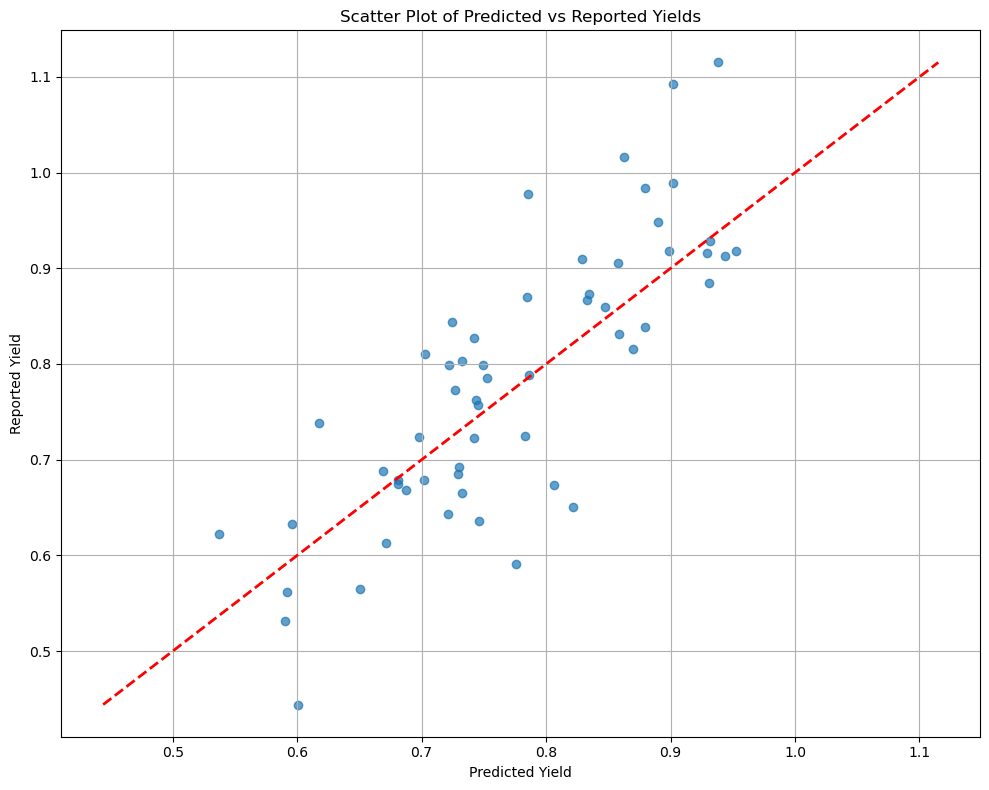

In [109]:
predictions = ridge_cv.predict(X_test)

# the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(predictions, y_test, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Predicted Yield')
plt.ylabel('Reported Yield')
plt.title('Scatter Plot of Predicted vs Reported Yields')
plt.grid(True)
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig('products/3.4.pdf', format='pdf')

# Report the final test set score and sample size
print(f'Final Test R^2 score: {test_r2:.4f}')
print(f'Test set sample size: {len(y_test)}')

Most of the points in the scatterplot are fairly well aligned with the reference line, suggesting that the model's predictions are reasonably accurate. The final test set score (R²) is 0.64, based on a test set sample of 57. This indicates that the model explains a substantial part of the variance in the performance data, although some deviations are observed, probably due to inherent variability or limitations of the features used for prediction

### Conclusion

This study demonstrates that vegetation indices, notably NDVI and EVI, are key indicators in explaining the variability of maize yields in Benin and Togo. The RidgeCV model performed better at Level 1 than at Level 2, underlining the importance of spatial resolution in predictive modeling. Aggregating data at regional level reduces sources of noise and improves the generalizability of the model.
However, to maximize the impact of these forecasts on food security and resource management, it would be relevant to develop models capable of predicting crop yields before or at the start of the agricultural season. Such models would enable decision-makers to take preventive measures earlier, thereby limiting the negative consequences of climatic hazards. Such early forecasts could guide resource allocation and the development of more effective resilience strategies.